# Long-Short Strategy, Part 5: Generating out-of-sample predictions

In this section, we'll start designing, implementing, and evaluating a trading strategy for US equities driven by daily return forecasts produced by gradient boosting models.

As in the previous examples, we'll lay out a framework and build a specific example that you can adapt to run your own experiments. There are numerous aspects that you can vary, from the asset class and investment universe to more granular aspects like the features, holding period, or trading rules. See, for example, the **Alpha Factor Library** in the [Appendix](../24_alpha_factor_library) for numerous additional features.

We'll keep the trading strategy simple and only use a single ML signal; a real-life application will likely use multiple signals from different sources, such as complementary ML models trained on different datasets or with different lookahead or lookback periods. It would also use sophisticated risk management, from simple stop-loss to value-at-risk analysis.

**Six notebooks** cover our workflow sequence:

1. [preparing_the_model_data](04_preparing_the_model_data.ipyny): we engineer a few simple features from the Quandl Wiki data 
2. [trading_signals_with_lightgbm_and_catboost](05_trading_signals_with_lightgbm_and_catboost.ipynb): we tune hyperparameters for LightGBM and CatBoost to select a model, using 2015/16 as our validation period. 
3. [evaluate_trading_signals](06_evaluate_trading_signals): we compare the cross-validation performance using various metrics to select the best model. 
4. [model_interpretation](07_model_interpretation.ipynb): we take a closer look at the drivers behind the best model's predictions.
5. `making_out_of_sample_predictions` (this noteboook): we predict returns for our out-of-sample period 2019-2023.
6. [backtesting_with_zipline](09_backtesting_with_zipline.ipynb): evaluate the historical performance of a long-short strategy based on our predictive signals using Zipline.

## Imports & Settings

In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
%matplotlib inline

import os
import sys
from pathlib import Path
from time import time

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from catboost import CatBoostRegressor, Pool
from scipy.stats import spearmanr

In [3]:
np.random.seed(42)

In [4]:
sys.path.insert(1, os.path.join(sys.path[0], ".."))
from utils import MultipleTimeSeriesCV

In [5]:
sns.set_style("whitegrid")

In [6]:
# YEAR = 252
YEAR = 12
datos_semanales = 1
if datos_semanales == 1:
    YEAR = 52
idx = pd.IndexSlice

In [7]:
scope_params = ["lookahead", "train_length", "test_length"]
daily_ic_metrics = [
    "daily_ic_mean",
    "daily_ic_mean_n",
    "daily_ic_median",
    "daily_ic_median_n",
]
lgb_train_params = [
    "learning_rate",
    "num_leaves",
    "feature_fraction",
    "min_data_in_leaf",
]
rf_train_params = [
    "bagging_fraction",
    "feature_fraction",
    "min_data_in_leaf",
    "max_depth",
]

## Generate Lightgbm predictions

### Model Configuration

In [8]:
base_params = dict(boosting="gbdt", objective="regression", random_state=42, verbose=-1)

categoricals = ["month", "sector"]

In [9]:
# dos semanas
lookahead = 1
store = Path(
    "../data/predictions.h5"
)  # no lo borramos previamente pq ya lo ha hecho el paso 5

### Get Data

In [10]:
# data = pd.read_hdf('data.h5', 'model_data').sort_index()
data = pd.read_hdf(
    "../data/assets.h5", "engineered_features"
).sort_index()  # modificado

In [11]:
data.tail()

return_1w  return_2w  return_3w  return_6w  return_12w  \
ticker date                                                                 
XLY    2025-04-20  -0.795165   0.347179  -1.166644  -1.322193   -2.166428   
       2025-04-27   2.333966   1.020322   1.543260   0.095384   -1.526403   
       2025-05-04   0.664376   2.085759   1.161500   0.296682   -1.033874   
       2025-05-11   0.166384   0.580557   1.692732   0.352185   -1.031115   
       2025-05-18   2.314708   1.715005   1.697617   2.205809   -0.070599   

                   return_52w     const    Mkt-RF       SMB       HML  ...  \
ticker date                                                            ...   
XLY    2025-04-20    1.164443 -0.005312  1.191913  0.203951 -0.032134  ...   
       2025-04-27    1.491123 -0.005312  1.191913  0.203951 -0.032134  ...   
       2025-05-04    1.579925 -0.005312  1.191913  0.203951 -0.032134  ...   
       2025-05-11    1.622472 -0.005312  1.191913  0.203951 -0.032134  ...   
       2025-05-18    2.358061 -0.005312  1.191913  0.203951 -0.032134  ...   

                   weekjobclaims_diff  weekjobclaims_chg  \
ticker date                                                
XLY    2025-04-20              7000.0           0.032407   
       2025-04-27             18000.0           0.080717   
       2025-05-04            -13000.0          -0.053942   
       2025-05-11            -13000.0          -0.053942   
       2025-05-18            -13000.0          -0.053942   

                   retail_sales_percent_diff  retail_sales_percent_chg  \
ticker date                                                              
XLY    2025-04-20                        1.2                       6.0   
       2025-04-27                        1.2                       6.0   
       2025-05-04                        1.2                       6.0   
       2025-05-11                        1.2                       6.0   
       2025-05-18                        1.2                       6.0   

                   retail_sales_diff  retail_sales_chg  us_asset_balance_diff  \
ticker date                                                                     
XLY    2025-04-20             8553.0          0.013859                -2237.0   
       2025-04-27             8553.0          0.013859                  435.0   
       2025-05-04             8553.0          0.013859                -1881.0   
       2025-05-11             8553.0          0.013859                  290.0   
       2025-05-18             8553.0          0.013859                  290.0   

                   us_asset_balance_chg  1y_yield_diff  1y_yield_chg  
ticker date                                                           
XLY    2025-04-20             -0.000530          -0.05     -0.012376  
       2025-04-27              0.000103          -0.04     -0.010025  
       2025-05-04             -0.000446           0.05      0.012658  
       2025-05-11              0.000069           0.05      0.012500  
       2025-05-18              0.000069           0.06      0.014815  

[5 rows x 89 columns]

In [12]:
# labels = sorted(data.filter(like='_fwd').columns)
labels = sorted(data.filter(like="target").columns)
features = data.columns.difference(labels).tolist()
# label = f'r{lookahead:02}_fwd'
label = "target_1w"  # modificado

In [13]:
label

'target_1w'

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 11934 entries, ('XLB', Timestamp('1999-12-26 00:00:00')) to ('XLY', Timestamp('2025-05-18 00:00:00'))
Data columns (total 89 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   return_1w                  11466 non-null  float64
 1   return_2w                  11466 non-null  float64
 2   return_3w                  11466 non-null  float64
 3   return_6w                  11466 non-null  float64
 4   return_12w                 11466 non-null  float64
 5   return_52w                 11466 non-null  float64
 6   const                      10872 non-null  float64
 7   Mkt-RF                     10872 non-null  float64
 8   SMB                        10872 non-null  float64
 9   HML                        10872 non-null  float64
 10  RMW                        10872 non-null  float64
 11  CMA                        10872 non-null  float64
 12  const_diff                

In [15]:
# Encuentra las filas con al menos un valor NaN
nan_cols = data.loc[idx[:, "2024":], features + [label]].isna().any(axis=0)

print(nan_cols[nan_cols == True])

target_1w    True
dtype: bool


In [16]:
# completamos con los valores del periodo anterior, para evitar que el último dato apareza nan
data = data.fillna(method="ffill")

In [17]:
# datos desde 2010
data = data.loc[idx[:, "2010":], features + [label]].dropna()

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 7227 entries, ('XLB', Timestamp('2010-01-03 00:00:00')) to ('XLY', Timestamp('2025-05-18 00:00:00'))
Data columns (total 85 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   1y_yield                   7227 non-null   float64
 1   1y_yield_chg               7227 non-null   float64
 2   1y_yield_diff              7227 non-null   float64
 3   CMA                        7227 non-null   float64
 4   CMA_diff                   7227 non-null   float64
 5   HML                        7227 non-null   float64
 6   HML_diff                   7227 non-null   float64
 7   Mkt-RF                     7227 non-null   float64
 8   Mkt-RF_diff                7227 non-null   float64
 9   RMW                        7227 non-null   float64
 10  RMW_diff                   7227 non-null   float64
 11  SMB                        7227 non-null   float64
 12  SMB_diff                   

In [19]:
# data.loc[idx[:, '2018'],:]

In [20]:
data.tail()

1y_yield  1y_yield_chg  1y_yield_diff       CMA  CMA_diff  \
ticker date                                                                    
XLY    2025-04-20      3.99     -0.012376          -0.05 -0.684762 -0.157044   
       2025-04-27      3.95     -0.010025          -0.04 -0.684762 -0.157044   
       2025-05-04      4.00      0.012658           0.05 -0.684762 -0.157044   
       2025-05-11      4.05      0.012500           0.05 -0.684762 -0.157044   
       2025-05-18      4.11      0.014815           0.06 -0.684762 -0.157044   

                        HML  HML_diff    Mkt-RF  Mkt-RF_diff       RMW  ...  \
ticker date                                                             ...   
XLY    2025-04-20 -0.032134  0.112095  1.191913     0.000752 -0.277251  ...   
       2025-04-27 -0.032134  0.112095  1.191913     0.000752 -0.277251  ...   
       2025-05-04 -0.032134  0.112095  1.191913     0.000752 -0.277251  ...   
       2025-05-11 -0.032134  0.112095  1.191913     0.000752 -0.277251  ...   
       2025-05-18 -0.032134  0.112095  1.191913     0.000752 -0.277251  ...   

                   vixoil  vixoil_chg  vixoil_diff  weekjobclaims  \
ticker date                                                         
XLY    2025-04-20   41.27   -0.188876        -9.61       223000.0   
       2025-04-27   43.53    0.054761         2.26       241000.0   
       2025-05-04   50.59    0.162187         7.06       228000.0   
       2025-05-11   39.82   -0.212888       -10.77       228000.0   
       2025-05-18   36.71   -0.078101        -3.11       228000.0   

                   weekjobclaims_chg  weekjobclaims_diff  yield_curve  \
ticker date                                                             
XLY    2025-04-20           0.032407              7000.0         0.00   
       2025-04-27           0.080717             18000.0        -0.03   
       2025-05-04          -0.053942            -13000.0         0.00   
       2025-05-11          -0.053942            -13000.0         0.03   
       2025-05-18          -0.053942            -13000.0         0.12   

                   yield_curve_chg  yield_curve_diff  target_1w  
ticker date                                                      
XLY    2025-04-20             -1.0             -0.14   2.333966  
       2025-04-27             -inf             -0.03   0.664376  
       2025-05-04             -1.0              0.03   0.166384  
       2025-05-11              inf              0.03   2.314708  
       2025-05-18              3.0              0.09   2.314708  

[5 rows x 85 columns]

In [21]:
for feature in categoricals:
    data[feature] = pd.factorize(data[feature], sort=True)[0]

In [22]:
lgb_data = lgb.Dataset(
    data=data[features],
    label=data[label],
    categorical_feature=categoricals,
    free_raw_data=False,
)

### Generate predictions

In [23]:
# tomamos los IC almacenados
lgb_ic = pd.read_hdf("../data/model_tuning.h5", "lgb/ic")
lgb_daily_ic = pd.read_hdf("../data/model_tuning.h5", "lgb/daily_ic")

In [24]:
# función para tomar los mejores parametros que saliernon en entrenamiento para un lookahead determinado


def get_lgb_params(data, t=5, best=0):
    param_cols = scope_params[1:] + lgb_train_params + ["boost_rounds"]
    df = data[data.lookahead == t].sort_values("ic", ascending=False).iloc[best]
    return df.loc[param_cols]

In [25]:
# para hacer más OOS que el 1 año definido inicialmente
years_OOS = 5

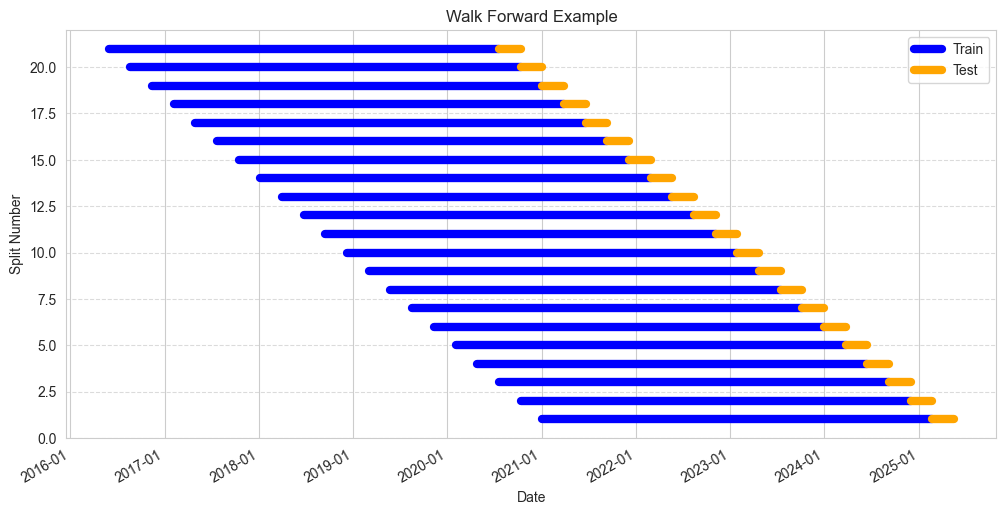

In [ ]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

# Generación de un gráfico para visualizar un ejemplo de walk-forward

train_period_length = 216
test_period_length = 12

n_splits = int(YEAR * years_OOS / test_period_length)
lookahead = 1

cv = MultipleTimeSeriesCV(
    n_splits=n_splits,
    test_period_length=test_period_length,
    lookahead=lookahead,
    train_period_length=train_period_length,
)

for train_idx, test_idx in cv.split(X=data):
    pass

# Crear el gráfico
plt.figure(figsize=(12, 6))

# Iterar sobre los splits y graficar
for i, (train, test) in enumerate(
    zip(cv.split_history["train_dates"], cv.split_history["test_dates"])
):
    # Graficar el periodo de entrenamiento
    plt.plot(
        [train["start"], train["end"]],
        [i + 1, i + 1],
        color="blue",
        label="Train" if i == 0 else "",
        linewidth=6,
    )
    # Graficar el periodo de test
    plt.plot(
        [test["start"], test["end"]],
        [i + 1, i + 1],
        color="orange",
        label="Test" if i == 0 else "",
        linewidth=6,
    )

# Configurar el formato del eje x
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gcf().autofmt_xdate()

# Etiquetas y título
plt.xlabel("Date")
plt.ylabel("Split Number")
plt.title("Walk Forward Example")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Mostrar el gráfico
plt.show()

In [29]:
# for par las 10 mejores configuracones de paramentros de las cuales almacenaremos sus predicciones
params_table = []

for position in range(10):
    params = get_lgb_params(lgb_daily_ic, t=lookahead, best=position)

    params = params.to_dict()  # parametros a diccionario

    print(f"\n\nParams: {params}")
    params_table.append(params)

    for p in ["min_data_in_leaf", "num_leaves"]:
        params[p] = int(params[p])
    train_length = int(
        params.pop("train_length")
    )  # Extrae y elimina el parámetro 'train_length' del diccionario de parámetros y lo convierte a un entero
    test_length = int(params.pop("test_length"))
    num_boost_round = int(params.pop("boost_rounds"))
    params.update(base_params)

    print(f"\nPosition: {position:02}")
    # print(params)

    # 1-year out-of-sample period
    # vamos a ir haciendo el walk forward con periodos de test de un mes, moveremos el modelo para volver a entrenar y predeciremos el siguiente mes
    n_splits = int(YEAR * years_OOS / test_length)
    # print(f"n_splits: {n_splits}, test_length: {test_length}, lookahead: {lookahead}, train_length: {train_length}")
    cv = MultipleTimeSeriesCV(
        n_splits=n_splits,
        test_period_length=test_length,
        lookahead=lookahead,
        train_period_length=train_length,
    )

    predictions = []
    start = time()

    for i, (train_idx, test_idx) in enumerate(cv.split(X=data), 1):
        print(i, end=" ", flush=True)

        # Crea un conjunto de datos de entrenamiento para LightGBM
        lgb_train = lgb_data.subset(
            used_indices=train_idx.tolist(), params=params
        ).construct()
        # Entrena el modelo LightGBM
        model = lgb.train(
            params=params,
            train_set=lgb_train,
            num_boost_round=num_boost_round,
        )

        test_set = data.iloc[test_idx, :]
        y_test = test_set.loc[:, label].to_frame("y_test")
        # Realiza predicciones en el conjunto de datos de prueba
        y_pred = model.predict(test_set.loc[:, model.feature_name()])
        predictions.append(y_test.assign(prediction=y_pred))

    if position == 0:
        test_predictions = pd.concat(predictions).rename(
            columns={"prediction": position}
        )
    else:
        test_predictions[position] = pd.concat(predictions).prediction

by_day = test_predictions.groupby(level="date")  # Agrupa las predicciones por fecha
for position in range(10):
    # Si es la primera iteración, calcula el coeficiente de correlación de Spearman
    # entre las predicciones y las etiquetas verdaderas y lo almacena en `ic_by_day`
    if position == 0:
        ic_by_day = by_day.apply(
            lambda x: spearmanr(x.y_test, x[position])[0]
        ).to_frame()
    else:
        ic_by_day[position] = by_day.apply(
            lambda x: spearmanr(x.y_test, x[position])[0]
        )
print(ic_by_day.describe())
test_predictions.to_hdf(store, f"lgb/test/{lookahead:02}")



Params: {'train_length': 216.0, 'test_length': 12.0, 'learning_rate': 0.3, 'num_leaves': 4.0, 'feature_fraction': 0.95, 'min_data_in_leaf': 100.0, 'boost_rounds': 50.0}

Position: 00
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 

Params: {'train_length': 216.0, 'test_length': 12.0, 'learning_rate': 0.3, 'num_leaves': 4.0, 'feature_fraction': 0.95, 'min_data_in_leaf': 100.0, 'boost_rounds': 100.0}

Position: 01
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 

Params: {'train_length': 216.0, 'test_length': 12.0, 'learning_rate': 0.3, 'num_leaves': 128.0, 'feature_fraction': 0.95, 'min_data_in_leaf': 200.0, 'boost_rounds': 100.0}

Position: 02
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 

Params: {'train_length': 216.0, 'test_length': 12.0, 'learning_rate': 0.3, 'num_leaves': 32.0, 'feature_fraction': 0.3, 'min_data_in_leaf': 100.0, 'boost_rounds': 50.0}

Position: 03
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 

Params: {'train_length': 216.0, 'test_

In [30]:
def show_table(df, image_name, title):
    fig, ax = plt.subplots(figsize=(10, 4), dpi=300)

    ax.axis("tight")
    ax.axis("off")

    exclude_cols = ["boosting", "objective", "random_state", "verbose"]
    df = df.drop(columns=exclude_cols, axis=1)

    table = ax.table(cellText=df.values, colLabels=df.columns, loc="center")

    table.auto_set_font_size(False)
    table.set_fontsize(10)

    table.auto_set_column_width(col=list(range(len(df.columns))))

    ax.set_title(title, fontsize=14, pad=-30)

    plt.savefig(
        f"../images/{image_name}.png", dpi=300, bbox_inches="tight", pad_inches=0.01
    )

    plt.show()

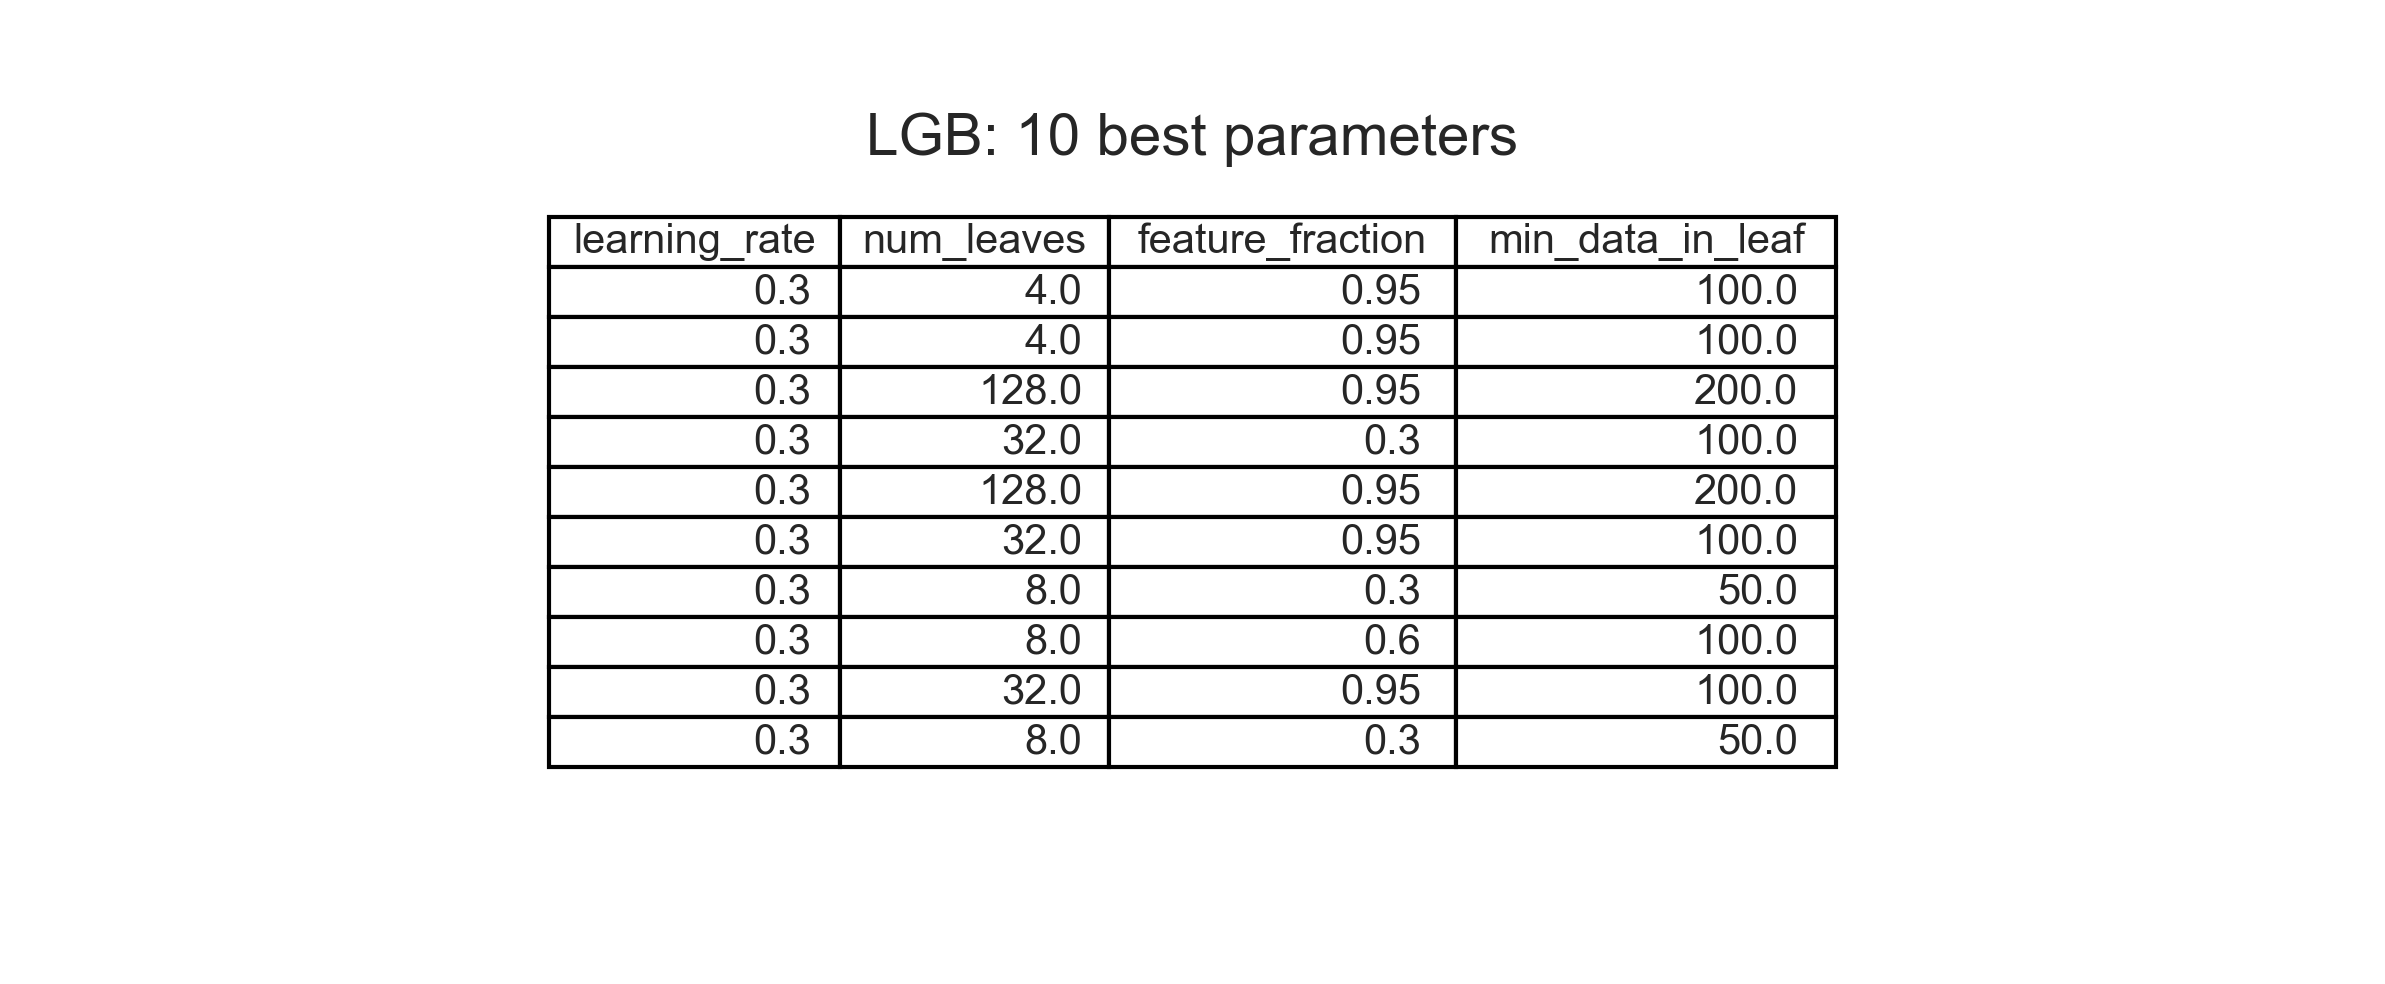

In [31]:
params_pd_table = pd.DataFrame(params_table)
show_table(params_pd_table, "lgb_10_best", "LGB: 10 best parameters")

#for par las 10 mejores configuracones de paramentros de las cuales almacenaremos sus predicciones
for position in range(10):
    params = get_lgb_params(lgb_daily_ic,
                            t=lookahead,
                            best=position)
    print (params)

params

## Generate RF predictions

### Model Configuration

In [32]:
base_params = dict(
    boosting="rf", objective="regression", random_state=42, bagging_freq=1, verbose=-1
)

# categoricals = ['year', 'month', 'sector', 'weekday']
categoricals = ["month", "sector"]

In [33]:
lookahead

1

In [34]:
store = Path("../data/predictions.h5")

### Get Data

In [35]:
# mismo que en Lightgbm
data.tail()

1y_yield  1y_yield_chg  1y_yield_diff       CMA  CMA_diff  \
ticker date                                                                    
XLY    2025-04-20      3.99     -0.012376          -0.05 -0.684762 -0.157044   
       2025-04-27      3.95     -0.010025          -0.04 -0.684762 -0.157044   
       2025-05-04      4.00      0.012658           0.05 -0.684762 -0.157044   
       2025-05-11      4.05      0.012500           0.05 -0.684762 -0.157044   
       2025-05-18      4.11      0.014815           0.06 -0.684762 -0.157044   

                        HML  HML_diff    Mkt-RF  Mkt-RF_diff       RMW  ...  \
ticker date                                                             ...   
XLY    2025-04-20 -0.032134  0.112095  1.191913     0.000752 -0.277251  ...   
       2025-04-27 -0.032134  0.112095  1.191913     0.000752 -0.277251  ...   
       2025-05-04 -0.032134  0.112095  1.191913     0.000752 -0.277251  ...   
       2025-05-11 -0.032134  0.112095  1.191913     0.000752 -0.277251  ...   
       2025-05-18 -0.032134  0.112095  1.191913     0.000752 -0.277251  ...   

                   vixoil  vixoil_chg  vixoil_diff  weekjobclaims  \
ticker date                                                         
XLY    2025-04-20   41.27   -0.188876        -9.61       223000.0   
       2025-04-27   43.53    0.054761         2.26       241000.0   
       2025-05-04   50.59    0.162187         7.06       228000.0   
       2025-05-11   39.82   -0.212888       -10.77       228000.0   
       2025-05-18   36.71   -0.078101        -3.11       228000.0   

                   weekjobclaims_chg  weekjobclaims_diff  yield_curve  \
ticker date                                                             
XLY    2025-04-20           0.032407              7000.0         0.00   
       2025-04-27           0.080717             18000.0        -0.03   
       2025-05-04          -0.053942            -13000.0         0.00   
       2025-05-11          -0.053942            -13000.0         0.03   
       2025-05-18          -0.053942            -13000.0         0.12   

                   yield_curve_chg  yield_curve_diff  target_1w  
ticker date                                                      
XLY    2025-04-20             -1.0             -0.14   2.333966  
       2025-04-27             -inf             -0.03   0.664376  
       2025-05-04             -1.0              0.03   0.166384  
       2025-05-11              inf              0.03   2.314708  
       2025-05-18              3.0              0.09   2.314708  

[5 rows x 85 columns]

In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 7227 entries, ('XLB', Timestamp('2010-01-03 00:00:00')) to ('XLY', Timestamp('2025-05-18 00:00:00'))
Data columns (total 85 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   1y_yield                   7227 non-null   float64
 1   1y_yield_chg               7227 non-null   float64
 2   1y_yield_diff              7227 non-null   float64
 3   CMA                        7227 non-null   float64
 4   CMA_diff                   7227 non-null   float64
 5   HML                        7227 non-null   float64
 6   HML_diff                   7227 non-null   float64
 7   Mkt-RF                     7227 non-null   float64
 8   Mkt-RF_diff                7227 non-null   float64
 9   RMW                        7227 non-null   float64
 10  RMW_diff                   7227 non-null   float64
 11  SMB                        7227 non-null   float64
 12  SMB_diff                   

In [37]:
data.loc[idx[:, "2024"], :]

1y_yield  1y_yield_chg  1y_yield_diff       CMA  CMA_diff  \
ticker date                                                                    
XLB    2024-01-07      4.84      0.010438           0.05  0.613125  0.262224   
       2024-01-14      4.65     -0.039256          -0.19  0.613125  0.262224   
       2024-01-21      4.84      0.040860           0.19  0.613125  0.262224   
       2024-01-28      4.78     -0.012397          -0.06  0.613125  0.262224   
       2024-02-04      4.81      0.006276           0.03  0.613125  0.262224   
...                     ...           ...            ...       ...       ...   
XLY    2024-12-01      4.30     -0.027149          -0.12 -0.684762 -0.157044   
       2024-12-08      4.19     -0.025581          -0.11 -0.684762 -0.157044   
       2024-12-15      4.24      0.011933           0.05 -0.684762 -0.157044   
       2024-12-22      4.27      0.007075           0.03 -0.684762 -0.157044   
       2024-12-29      4.20     -0.016393          -0.07 -0.684762 -0.157044   

                        HML  HML_diff    Mkt-RF  Mkt-RF_diff       RMW  ...  \
ticker date                                                             ...   
XLB    2024-01-07 -0.111875 -0.224489  1.097488     0.001968  0.347848  ...   
       2024-01-14 -0.111875 -0.224489  1.097488     0.001968  0.347848  ...   
       2024-01-21 -0.111875 -0.224489  1.097488     0.001968  0.347848  ...   
       2024-01-28 -0.111875 -0.224489  1.097488     0.001968  0.347848  ...   
       2024-02-04 -0.111875 -0.224489  1.097488     0.001968  0.347848  ...   
...                     ...       ...       ...          ...       ...  ...   
XLY    2024-12-01 -0.032134  0.112095  1.191913     0.000752 -0.277251  ...   
       2024-12-08 -0.032134  0.112095  1.191913     0.000752 -0.277251  ...   
       2024-12-15 -0.032134  0.112095  1.191913     0.000752 -0.277251  ...   
       2024-12-22 -0.032134  0.112095  1.191913     0.000752 -0.277251  ...   
       2024-12-29 -0.032134  0.112095  1.191913     0.000752 -0.277251  ...   

                   vixoil  vixoil_chg  vixoil_diff  weekjobclaims  \
ticker date                                                         
XLB    2024-01-07   36.07   -0.004141        -0.15       199000.0   
       2024-01-14   40.64    0.126698         4.57       193000.0   
       2024-01-21   35.79   -0.119341        -4.85       223000.0   
       2024-01-28   34.78   -0.028220        -1.01       225000.0   
       2024-02-04   34.85    0.002013         0.07       214000.0   
...                   ...         ...          ...            ...   
XLY    2024-12-01   34.95   -0.022104        -0.79       225000.0   
       2024-12-08   30.98   -0.113591        -3.97       239000.0   
       2024-12-15   34.92    0.127179         3.94       222000.0   
       2024-12-22   29.27   -0.161798        -5.65       219000.0   
       2024-12-29   30.21    0.032115         0.94       209000.0   

                   weekjobclaims_chg  weekjobclaims_diff  yield_curve  \
ticker date                                                             
XLB    2024-01-07           0.005051              1000.0        -1.42   
       2024-01-14          -0.030151             -6000.0        -1.49   
       2024-01-21           0.155440             30000.0        -1.30   
       2024-01-28           0.008969              2000.0        -1.29   
       2024-02-04          -0.048889            -11000.0        -1.40   
...                              ...                 ...          ...   
XLY    2024-12-01           0.041667              9000.0        -0.40   
       2024-12-08           0.062222             14000.0        -0.27   
       2024-12-15          -0.071130            -17000.0         0.06   
       2024-12-22          -0.013514             -3000.0         0.18   
       2024-12-29          -0.045662            -10000.0         0.31   

                   yield_curve_chg  yield_curve_diff  target_1w  
ticker date                         

In [38]:
data[feature]

ticker  date      
XLB     2010-01-03    0
        2010-01-10    0
        2010-01-17    0
        2010-01-24    0
        2010-01-31    0
                     ..
XLY     2025-04-20    8
        2025-04-27    8
        2025-05-04    8
        2025-05-11    8
        2025-05-18    8
Name: sector, Length: 7227, dtype: int64

In [39]:
for feature in categoricals:
    data[feature] = pd.factorize(data[feature], sort=True)[0]

In [40]:
lgb_data = lgb.Dataset(
    data=data[features],
    label=data[label],
    categorical_feature=categoricals,
    free_raw_data=False,
)

### Generate predictions

In [41]:
# tomamos los IC almacenados
rf_ic = pd.read_hdf("../data/model_tuning.h5", "rf/ic")
rf_daily_ic = pd.read_hdf("../data/model_tuning.h5", "rf/daily_ic")

In [42]:
rf_daily_ic

,lookahead,train_length,test_length,bagging_fraction,feature_fraction,min_data_in_leaf,max_depth,boost_rounds,ic
0,1,52,1,0.75,0.75,89,-1,50,-0.000089
1,1,52,1,0.75,0.75,89,-1,100,-0.005048
2,1,52,1,0.75,0.75,89,10,50,-0.000089
3,1,52,1,0.75,0.75,89,10,100,-0.005048
4,1,52,1,0.75,0.75,100,-1,50,0.008015
...,...,...,...,...,...,...,...,...,...
127,1,216,12,0.95,0.75,200,5,100,-0.024088
128,1,216,12,0.95,0.95,89,-1,50,0.009243
129,1,216,12,0.95,0.95,89,-1,100,-0.001887
130,1,216,12,0.95,0.95,200,10,50,-0.016148


In [43]:
rf_daily_ic["test_length"] = 1

In [44]:
# función para tomar los mejores parametros que saliernon en entrenamiento para un lookahead determinado


def get_rf_params(data, t=5, best=0):
    param_cols = scope_params[1:] + rf_train_params + ["boost_rounds"]
    df = data[data.lookahead == t].sort_values("ic", ascending=False).iloc[best]
    return df.loc[param_cols]

In [45]:
# para hacer más OOS que el 1 año definido inicialmente
# years_OOS=1

In [46]:
# for par las 10 mejores configuracones de paramentros de las cuales almacenaremos sus predicciones
params_table = []

for position in range(10):
    params = get_rf_params(rf_daily_ic, t=lookahead, best=position)

    params = params.to_dict()  # parametros a diccionario

    print(f"\n\nParams: {params}")
    params_table.append(params)

    for p in ["min_data_in_leaf", "max_depth"]:
        params[p] = int(params[p])
    train_length = int(
        params.pop("train_length")
    )  # Extrae y elimina el parámetro 'train_length' del diccionario de parámetros y lo convierte a un entero
    test_length = int(params.pop("test_length"))
    num_boost_round = int(params.pop("boost_rounds"))
    params.update(base_params)

    print(f"\nPosition: {position:02}")
    print(params)

    # 1-year out-of-sample period
    # vamos a ir haciendo el walk forward con periodos de test de un mes, moveremos el modelo para volver a entrenar y predeciremos el siguiente mes
    n_splits = int(YEAR * years_OOS / test_length)
    cv = MultipleTimeSeriesCV(
        n_splits=n_splits,
        test_period_length=test_length,
        lookahead=lookahead,
        train_period_length=train_length,
    )

    predictions = []
    start = time()
    for i, (train_idx, test_idx) in enumerate(cv.split(X=data), 1):
        print(i, end=" ", flush=True)

        # Crea un conjunto de datos de entrenamiento para LightGBM
        lgb_train = lgb_data.subset(
            used_indices=train_idx.tolist(), params=params
        ).construct()
        # Entrena el modelo LightGBM
        model = lgb.train(
            params=params,
            train_set=lgb_train,
            num_boost_round=num_boost_round,
            #   verbose_eval=False
        )

        test_set = data.iloc[test_idx, :]
        y_test = test_set.loc[:, label].to_frame("y_test")
        # Realiza predicciones en el conjunto de datos de prueba
        y_pred = model.predict(test_set.loc[:, model.feature_name()])
        predictions.append(y_test.assign(prediction=y_pred))
        # if position == 0:
        #    break
    # if position == 0:
    #    break
    if position == 0:
        test_predictions = pd.concat(predictions).rename(
            columns={"prediction": position}
        )
    else:
        test_predictions[position] = pd.concat(predictions).prediction

by_day = test_predictions.groupby(level="date")  # Agrupa las predicciones por fecha
for position in range(10):
    # Si es la primera iteración, calcula el coeficiente de correlación de Spearman
    # entre las predicciones y las etiquetas verdaderas y lo almacena en `ic_by_day`
    if position == 0:
        ic_by_day = by_day.apply(
            lambda x: spearmanr(x.y_test, x[position])[0]
        ).to_frame()
    else:
        ic_by_day[position] = by_day.apply(
            lambda x: spearmanr(x.y_test, x[position])[0]
        )
print(ic_by_day.describe())
test_predictions.to_hdf(store, f"rf/test/{lookahead:02}")



Params: {'train_length': 52.0, 'test_length': 1.0, 'bagging_fraction': 0.95, 'feature_fraction': 0.95, 'min_data_in_leaf': 89.0, 'max_depth': 5.0, 'boost_rounds': 100.0}

Position: 00
{'bagging_fraction': 0.95, 'feature_fraction': 0.95, 'min_data_in_leaf': 89, 'max_depth': 5, 'boosting': 'rf', 'objective': 'regression', 'random_state': 42, 'bagging_freq': 1, 'verbose': -1}
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 18

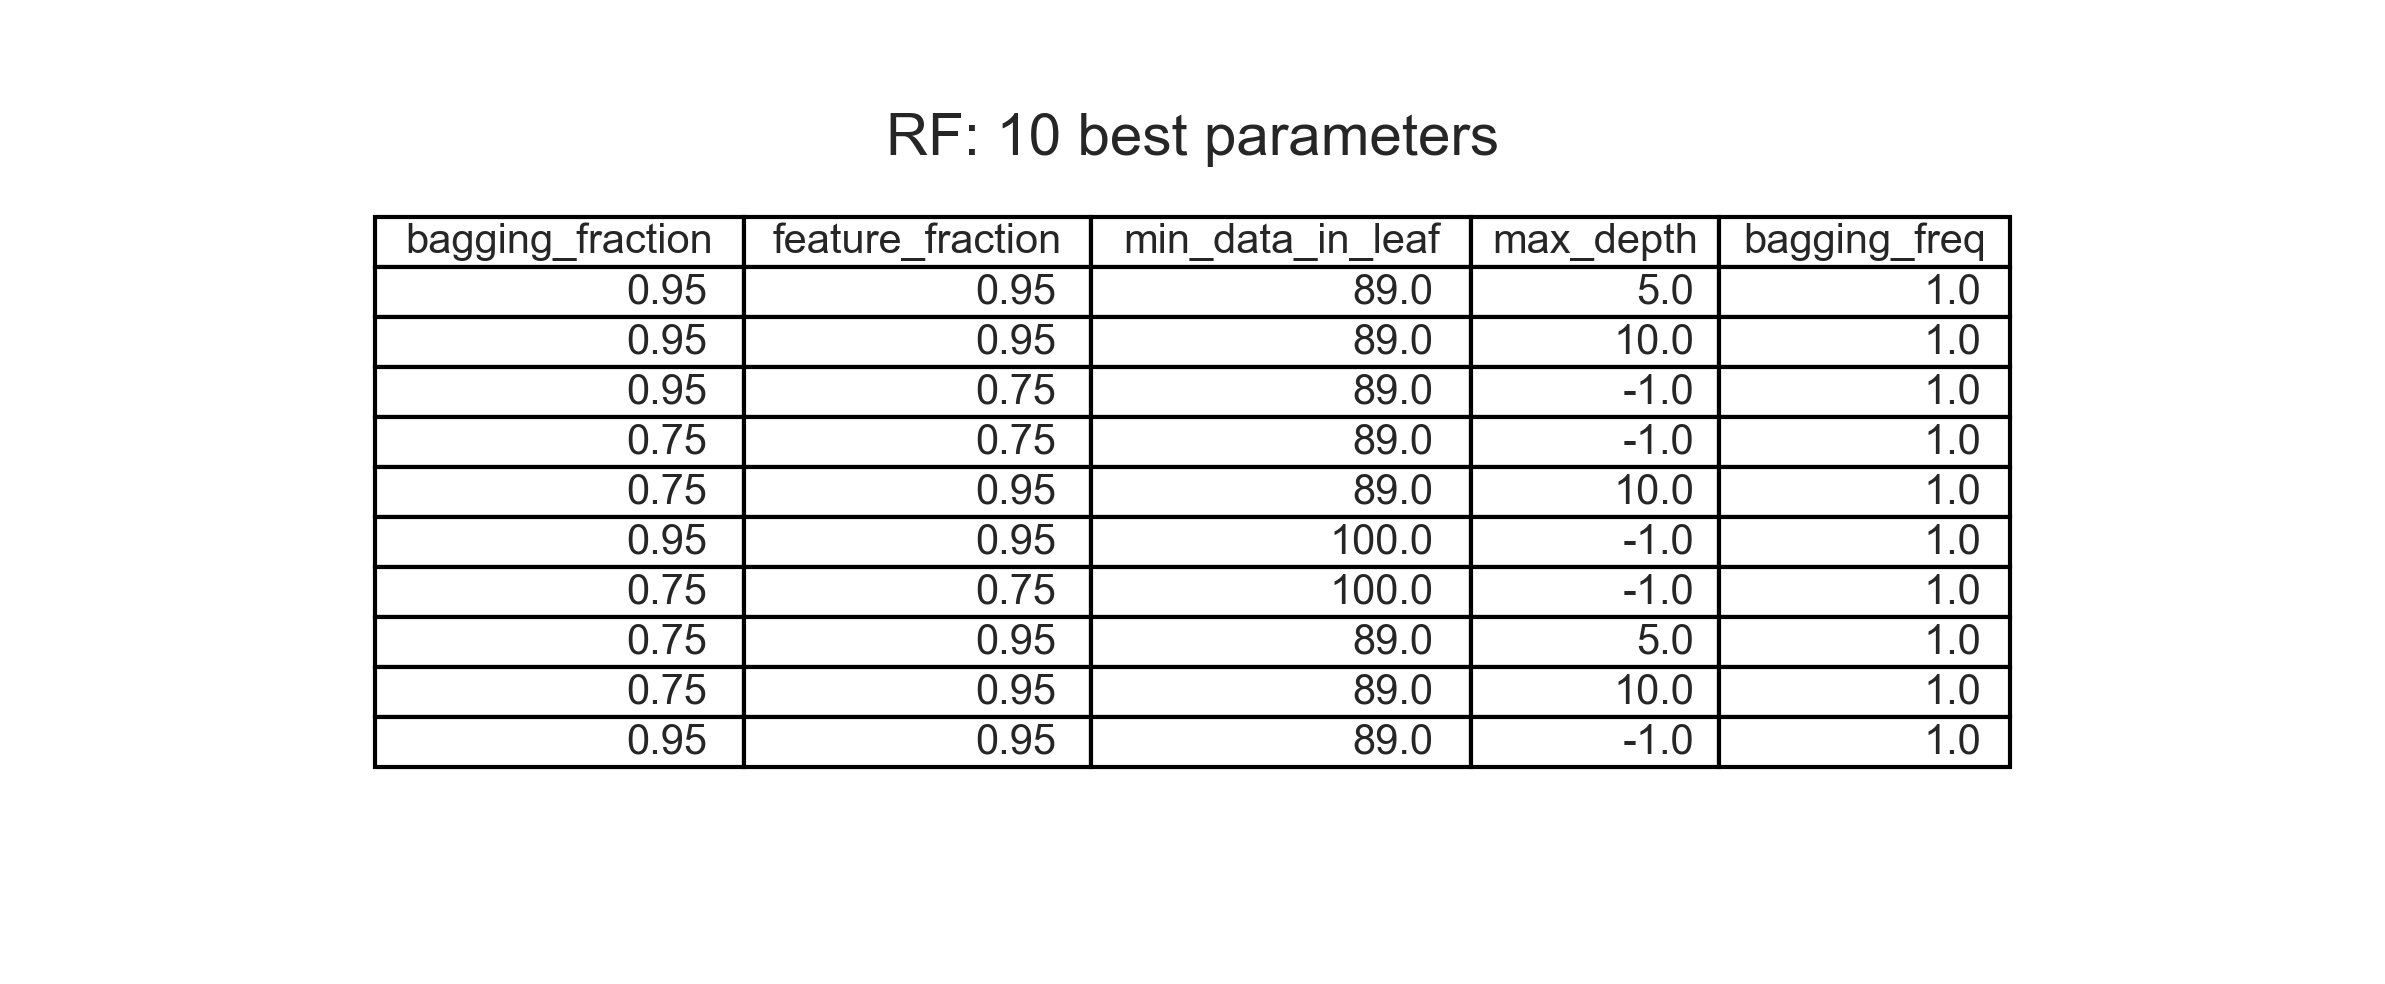

In [47]:
params_pd_table = pd.DataFrame(params_table)
show_table(params_pd_table, "rf_10_best", "RF: 10 best parameters")

In [48]:
n_splits = int(YEAR * years_OOS / test_length)

In [49]:
test_length

1

In [50]:
ic_by_day

,0,1,2,3,4,5,6,7,8,9
date,,,,,,,,,,
2020-05-31,NaN,NaN,0.339464,-0.661094,-0.610257,0.456435,-0.457693,-0.821584,-0.821584,NaN
2020-06-07,NaN,NaN,-0.623850,-0.558595,-0.555738,-0.410792,-0.614919,NaN,NaN,-0.342327
2020-06-14,NaN,NaN,0.521749,0.433013,0.433013,0.521749,0.461062,-0.547723,-0.547723,0.521749
2020-06-21,NaN,NaN,0.000000,-0.033615,-0.400000,-0.365148,0.136797,0.136931,0.136931,-0.365148
2020-06-28,0.0,0.0,0.247717,0.186339,0.069007,0.149071,0.186339,NaN,NaN,0.000000
...,...,...,...,...,...,...,...,...,...,...
2025-04-20,NaN,NaN,0.795678,0.703005,0.816667,0.766812,0.436990,NaN,NaN,0.703005
2025-04-27,NaN,NaN,-0.322044,-0.350000,-0.333333,-0.118153,-0.161739,0.182574,0.182574,-0.195789
2025-05-04,NaN,NaN,-0.136931,-0.073398,-0.100844,0.159670,-0.051075,NaN,NaN,0.049801


In [51]:
f"rf/test/{lookahead:02}"

'rf/test/01'

In [52]:
test_set.loc["XLU", model.feature_name()]

,1y_yield,1y_yield_chg,1y_yield_diff,CMA,CMA_diff,HML,HML_diff,Mkt-RF,Mkt-RF_diff,RMW,...,vix_diff,vixoil,vixoil_chg,vixoil_diff,weekjobclaims,weekjobclaims_chg,weekjobclaims_diff,yield_curve,yield_curve_chg,yield_curve_diff
date,,,,,,,,,,,,,,,,,,,,,
2020-05-31,0.17,0.133333,0.02,0.225786,0.423416,0.287064,0.345645,0.57451,0.419891,-0.082466,...,-0.65,69.23,-0.185338,-15.75,1639000.0,-0.146799,-282000.0,0.51,-0.055556,-0.03


In [53]:
num_boost_round

50

In [54]:
params

{'bagging_fraction': 0.95,
 'feature_fraction': 0.95,
 'min_data_in_leaf': 89,
 'max_depth': -1,
 'boosting': 'rf',
 'objective': 'regression',
 'random_state': 42,
 'bagging_freq': 1,
 'verbose': -1}

In [55]:
model.feature_name()

['1y_yield',
 '1y_yield_chg',
 '1y_yield_diff',
 'CMA',
 'CMA_diff',
 'HML',
 'HML_diff',
 'Mkt-RF',
 'Mkt-RF_diff',
 'RMW',
 'RMW_diff',
 'SMB',
 'SMB_diff',
 'const',
 'const_diff',
 'corp_oas',
 'corp_oas_chg',
 'corp_oas_diff',
 'empleo_chg',
 'empleo_diff',
 'eu_hy_oas',
 'eu_hy_oas_chg',
 'eu_hy_oas_diff',
 'hy_oas',
 'hy_oas_chg',
 'hy_oas_diff',
 'inflacion',
 'inflacion_chg',
 'inflacion_diff',
 'leading',
 'leading_chg',
 'leading_diff',
 'momentum_12',
 'momentum_2',
 'momentum_3',
 'momentum_3_12',
 'momentum_52',
 'momentum_6',
 'month',
 'oil',
 'oil_chg',
 'oil_diff',
 'real_gdp',
 'real_gdp_chg',
 'real_gdp_diff',
 'recession',
 'recession_chg',
 'recession_diff',
 'retail_sales',
 'retail_sales_chg',
 'retail_sales_diff',
 'retail_sales_percent',
 'retail_sales_percent_chg',
 'retail_sales_percent_diff',
 'return_12w',
 'return_1w',
 'return_1w_t-1',
 'return_1w_t-2',
 'return_1w_t-3',
 'return_1w_t-4',
 'return_1w_t-5',
 'return_1w_t-6',
 'return_2w',
 'return_3w',
 '

In [56]:
# for par las 10 mejores configuracones de paramentros de las cuales almacenaremos sus predicciones
for position in range(10):
    params = get_rf_params(rf_daily_ic, t=lookahead, best=position)
    print(params)

train_length         52.00
test_length           1.00
bagging_fraction      0.95
feature_fraction      0.95
min_data_in_leaf     89.00
max_depth             5.00
boost_rounds        100.00
Name: 53, dtype: float64
train_length         52.00
test_length           1.00
bagging_fraction      0.95
feature_fraction      0.95
min_data_in_leaf     89.00
max_depth            10.00
boost_rounds        100.00
Name: 55, dtype: float64
train_length        216.00
test_length           1.00
bagging_fraction      0.95
feature_fraction      0.75
min_data_in_leaf     89.00
max_depth            -1.00
boost_rounds         50.00
Name: 120, dtype: float64
train_length        216.00
test_length           1.00
bagging_fraction      0.75
feature_fraction      0.75
min_data_in_leaf     89.00
max_depth            -1.00
boost_rounds         50.00
Name: 60, dtype: float64
train_length        216.00
test_length           1.00
bagging_fraction      0.75
feature_fraction      0.95
min_data_in_leaf     89.00
max_dept